<font color='blue'> **13** </font> 

In [1]:
from modflow_devtools.misc import get_env;write=get_env("WRITE",True);run=get_env("RUN",True);plot=get_env("PLOT",True);plot_show=get_env("PLOT_SHOW",True);plot_save=get_env("PLOT_SAVE",True)
import os     ; import matplotlib.pyplot as plt      ; import numpy as np  ; import pickle   ; from pathlib import Path ; import pathlib as pl   ; import matplotlib as mpl
import flopy  ; from flopy.plot.styles import styles ; import pandas as pd ; exe_name = 'E:\\15_REPOS\\00_BETAMI\\bin\\mf6.exe' 
_R  = Path("./_R")       ; _R.mkdir(exist_ok=True)   ; T13   = Path("./_R/T13")   ; T13.mkdir(exist_ok=True)     ; path =     'E:/15_REPOS/02_Beta-Me/data/MF6/13_ex-gwf-sfr-p01b'
REF1 = Path('E:/15_REPOS/02_Beta-Me/data/MF6/13_ex-gwf-sfr-p01b')                 ; ID= "e13"                    ; REF2 =Path('E:/15_REPOS/02_Beta-Me/data/MF6/13_sfr')
with open(REF2/ "a_tdis_ds"     ,'rb') as handle:   TDIS  = pickle.load(handle)   
with open(REF2/ "a_extwc"       ,'rb') as handle:   EXT   = pickle.load(handle)   
with open(REF2/ "a_finf"        ,'rb') as handle:   FIN   = pickle.load(handle)  

with open(REF2/ "a_wel_spd"     ,'rb') as handle:   WEL_S = pickle.load(handle)   
with open(REF2/ "a_sfr_pakdata" ,'rb') as handle:   SFR_P = pickle.load(handle) 
with open(REF2/ "a_sfr_conn"    ,'rb') as handle:   SFR_C = pickle.load(handle) 
with open(REF2/ "a_uzf_pakdata" ,'rb') as handle:   UZF_P = pickle.load(handle) 
with open(REF2/ "a_mvr_spd"     ,'rb') as handle:   MVR_S = pickle.load(handle)   
with open(REF2/ "a_sfr_obs_dict",'rb') as handle:   SFR_O = pickle.load(handle)  
with open(REF2/ "a_sfr_obs_dict", 'rb') as handle:  SFR_O = pickle.load(handle)   
with open(REF2/ "a_lak_obs_dict", 'rb') as handle:  LAK_O = pickle.load(handle)   
with open(REF2/ "a_uzf_obs_dict", 'rb') as handle:  UZF_O = pickle.load(handle)   

In [2]:
SY1  = np.loadtxt(REF1/"sy1.txt"  , dtype = float)   ; STRT1= np.loadtxt(REF1/"strt1.txt", dtype=float)  ; IDO1  = np.loadtxt(REF1/"idomain.txt" , dtype = int)   
TOP  = np.loadtxt(REF1/"top1.txt" , dtype=float)     ; BOT1 = np.loadtxt(REF1/"BOT1.txt" , dtype=float)  ; K11L1 = np.loadtxt(REF1/"k11_lay1.txt", dtype = float) * 2.5
nlay=2;nrow=15;ncol=10  ;SH3D  = (nlay,nrow,ncol)    ; STRT2=STRT1 ; STRT =[STRT1   ,STRT2]              ; IDO   = [IDO1    ,IDO1 ]
FP = os.path.join(path,"lakes.txt")                  ; LOK = np.ones(SH3D, dtype=int) * -1          ; LOK[0, :, :] = np.loadtxt(FP, dtype=int) - 1  ; LOK = np.ma.masked_where(LOK < 0, LOK)
BOT2 = np.ones_like(BOT1)*300.0  ;BOTM=[BOT1,BOT2]   ; K11L2=np.ones_like(K11L1)*0.35e-2            ; K11 =[K11L1,K11L2];K33=0.5e-5                 ; SY2=np.ones_like(SY1)*0.20;SY=[SY1,SY2]

length_units = "feet"   ; delr=5000;delc=5000;nper = 24 ; lake_leakance = 0.000000002 ; SS = 0.000001                                     # K11_stream = 0.002 ;  K11_basin = "varies"
time_units = "seconds"  ; evap_rate = 0.000000095       ; ext_depth = 15              ; extents = (0.0,delr*ncol,0.0,delc*nrow)                  #; SY_stream = 0.2   ; SY_basin = 0.1      
GHB_S = [[0,12,0,988.0,0.038],[0,13,8,1045.0,0.038]]    ; SFR_D = [[3,0,9,"UPTO"]]    ; SFR_S   = [[0,"inflow",25.0] ,[3,"diversion",0,10.0] ,[15,"inflow",10.0] ,[25,"inflow",150.0]]     
UZF_S = {}                   ; pET   = 1.00e-08         ; extdp = 15.0 ; ha = 0.0     ; HT1     = 0.0    ;HT2 = 0.0
for tm in range(len(TDIS)):
    sp = []                   ; iuzno = 0 
    for i in range(len(EXT)):
        sp.append((iuzno, FIN[tm][i], pET, extdp, EXT[i], ha, HT1, HT2)) ; iuzno += 1
    UZF_S.update({int(tm): sp})

lak_stage   = (1040.0, 1010.0)                                                        ; MVR_P = [["UZF-1"], ["SFR-1"], ["LAK-1"], ["WEL-1"]]   ; maxpackages = len(MVR_P)  ; max_mvr = 200   
lak_outlets = [[0, 0, -1, "MANNING", 1040.0004, 12.0, 0.29999999e-01, 0.14285709e-02],
               [1, 1, -1, "MANNING", 1000.0000, 60.0, 0.29999999e-01, 0.12500000e-02]]
LK_S     = {0: [[0, "rainfall", 0.500e-07],[0, "evaporation", 0.100e-07],[0, "runoff", 1.50],[0, "withdrawal", 0.00],
                [1, "rainfall", 0.120e-07],[1, "evaporation", 0.110e-07],[1, "runoff", 3.00],[1, "withdrawal", 0.12]]}

In [3]:
def build_models():
    global LAK_ID
    SFR_OBS = f"{ID}.sfr.obs" ; LAK_OBS = f"{ID}.lak.obs" ; UZF_OBS = f"{ID}.uzf.obs"

    sim = flopy.mf6.MFSimulation (sim_name=ID, sim_ws=T13 ,exe_name="mf6")                                       ;flopy.mf6.ModflowTdis (sim, nper=nper, perioddata=TDIS,time_units=time_units)
    flopy.mf6.ModflowIms  (sim,print_option="summary"  ,complexity="complex" ,outer_dvclose=1.0e-4               ,outer_maximum=2000 ,under_relaxation="dbd"    ,linear_acceleration="BICGSTAB",
          under_relaxation_theta=0.7   ,under_relaxation_kappa=0.08          ,under_relaxation_gamma=0.05        ,under_relaxation_momentum=0.0 ,backtracking_number=20,
          backtracking_tolerance=2.0   ,backtracking_reduction_factor=0.2    ,backtracking_residual_limit=5.0e-4 ,inner_dvclose=1.0e-5          ,rcloserecord="0.0001 relative_rclose",
          inner_maximum=100            , relaxation_factor=0.0               ,number_orthogonalizations=2        ,preconditioner_levels=8       ,preconditioner_drop_tolerance=0.001)
    gwf = flopy.mf6.ModflowGwf (sim, modelname=ID, newtonoptions="newton", save_flows=True)
    flopy.mf6.ModflowGwfdis      (gwf, length_units=length_units    ,nlay=nlay    ,nrow=nrow,ncol=ncol  ,delr=delr,delc=delc  ,idomain=IDO,top=TOP,botm=BOTM)
    flopy.mf6.ModflowGwfnpf      (gwf, alternative_cell_averaging="AMT-HMK"       ,icelltype=1,k=K11,k33=K33,save_specific_discharge=True)                   ;flopy.mf6.ModflowGwfic(gwf,strt=STRT) 
    flopy.mf6.ModflowGwfsto      (gwf, iconvert=1 ,sy=SY ,ss=SS ,steady_state={0: True}   ,transient={1: True})                              ;flopy.mf6.ModflowGwfghb(gwf,stress_period_data=GHB_S)
    flopy.mf6.ModflowGwfwel      (gwf,print_input=True ,print_flows=True ,save_flows=True ,mover=True ,pname="WEL-1",stress_period_data=WEL_S)
# ________________________________________________________________________________
    SFRA = flopy.mf6.ModflowGwfsfr(gwf ,print_flows=True ,print_stage=True    ,save_flows=True   ,mover=True      ,boundnames=True ,budget_filerecord=ID+".sfr.bud",maximum_depth_change=0.1e-05,
                pname="SFR-1" ,length_conversion=3.28081 ,nreaches=len(SFR_P) ,packagedata=SFR_P ,connectiondata=SFR_C ,diversions=SFR_D,perioddata=SFR_S               ,filename=f"{ID}.sfr")
    (LAK_ID, LAK_D, LAK_C) = (flopy.mf6.utils.get_lak_connections(gwf.modelgrid,LOK ,idomain =  gwf.dis.idomain.array,bedleak=lake_leakance))  ; lak_pakdata=[]
    for key in LAK_D.keys():   lak_pakdata.append([key, lak_stage[key], LAK_D[key]])
    LAKA = flopy.mf6.ModflowGwflak (gwf ,print_stage=True,print_flows=True  ,save_flows=True  ,budget_filerecord=ID+".lak.bud" ,length_conversion=3.28081,mover=True,pname="LAK-1",
          boundnames=False, nlakes=len(lak_pakdata) ,noutlets=len(lak_outlets)  ,outlets=lak_outlets  ,packagedata=lak_pakdata  ,connectiondata=LAK_C  ,perioddata=LK_S  ,filename=f"{ID}.lak")
    UZFA = flopy.mf6.ModflowGwfuzf  (gwf,nuzfcells=len(UZF_P),boundnames=True ,ntrailwaves=10    ,nwavesets=50     ,print_flows=False,save_flows=True ,simulate_et=True ,linear_gwet=True,
                                    simulate_gwseep=True    ,mover=True      ,packagedata=UZF_P ,perioddata=UZF_S ,budget_filerecord=f"{ID}.uzf.bud" ,pname="UZF-1"    ,filename=f"{ID}.uzf")
    UZFA.obs.initialize (filename=UZF_OBS, continuous=UZF_O, print_input=True)                                         ; LAKA.obs.initialize (filename=LAK_OBS, continuous=LAK_O, digits=10)
    SFRA.obs.initialize (filename=SFR_OBS, continuous=SFR_O, print_input=True,digits=10)                               ; gwf.dis.idomain = LAK_ID   ; HF = f"{ID}.hds"  ; BF = f"{ID}.cbc"
# ________________________________________________________________________________
    flopy.mf6.ModflowGwfmvr (gwf,maxmvr=max_mvr,print_flows=True,maxpackages=maxpackages,packages=MVR_P,perioddata=MVR_S,pname="MVR-1",budget_filerecord=ID+".mvr.bud",filename=f"{ID}.mvr")                    
    flopy.mf6.ModflowGwfoc(gwf ,head_filerecord=HF ,budget_filerecord=BF ,saverecord=[("HEAD", "LAST"), ("BUDGET", "LAST")])    ; return sim
def write_models(sim, silent=True):  sim.write_simulation(silent=silent)
def run_models(sim, silent=True):    success, buff = sim.run_simulation(silent=silent)   ; assert success, buff
def simulation(idx, silent=True):    
    sim = build_models()   
    if write:  write_models(sim, silent=silent)
    if run:    run_models(sim, silent=silent)
simulation(0)

In [4]:
sim = flopy.mf6.MFSimulation.load(sim_ws= T13 ,exe_name=exe_name, verbosity_level=0) ; gwf = sim.get_model(ID)     ; print("OC package_Flow :",gwf.oc.output.methods()) 
HOBJ=gwf.output.head()  ;COBJ=gwf.output.budget()  ; kstpkper = HOBJ.get_kstpkper()                                

OC package_Flow : ['list()', 'zonebudget()', 'budget()', 'budgetcsv()', 'head()']


In [5]:
%%capture  
fig = plt.figure(figsize=(12, 10), constrained_layout=False)                                             ; GS=mpl.gridspec.GridSpec(ncols=10, nrows=7, figure=fig, wspace=5)
plt.axis("off")               ; axes = []                ; axes.append(fig.add_subplot(GS[:6, :5]))      ; axes.append(fig.add_subplot(GS[:6, 5:], sharey=axes[0]))
for ax in axes:
    ax.set_xlim(extents[:2])  ; ax.set_ylim(extents[2:]) ; ax.set_aspect("equal")
axes.append(fig.add_subplot(GS[6:, :]))                  ; ax = axes[-1]          ; ax.set_xlim(0, 1)  ; ax.set_ylim(0, 1)  ; ax.axis("off") ; ax.set_xticks([])   ; ax.set_yticks([]) 
ax.spines["top"].set_color("none") ; ax.spines["bottom"].set_color("none")        ; ax.spines["left"].set_color("none")     ; ax.spines["right"].set_color("none") ; ax.patch.set_alpha(0.0)
# __________________________________________________________________________________________________________________________________________________________________
ax = axes[0]                       ; mm = flopy.plot.PlotMapView(gwf, ax=ax, extent=extents)     ; TO=mm.plot_array(TOP,vmin=1000,vmax=1120    ,masked_values=(0,1e30,-1e30) ,alpha=0.5)
mm.plot_bc("SFR", color="green")   ; cv = mm.contour_array(TOP,levels=np.arange(1000, 1100, 20)  ,linewidths=0.5,linestyles="-",colors="black" ,masked_values=(0,1e30,-1e30))
plt.clabel(cv, fmt="%1.0f")        ; mm.plot_inactive(color_noflow="0.5")                        ; mm.plot_grid(lw=0.5, color="black")
ax.set_xlabel("in feet")           ; cbar = plt.colorbar(TO, shrink=0.8, orientation="horizontal", ax=ax, format="%.0f")     ; cbar.ax.tick_params(size=0)
ax.set_ylabel("in feet")           ; cbar.ax.set_xlabel(r"Land surface elevation, $ft$")         ; styles.heading(ax, heading="Land surface elevation", idx=0) 
ax = axes[1]  # _____________________________________________________________________________________________________________________________________________________
mm = flopy.plot.PlotMapView(gwf, ax=ax, extent=extents)                          ; bot_coll = mm.plot_array(BOTM, vmin=950, vmax=1100, masked_values=(0, 1e30, -1e30), alpha=0.5)
mm.plot_bc("GHB", color="purple")      ; mm.plot_bc("WEL", color="red", kper=1)  ; mm.plot_bc("LAK", color="yellow", kper=1)  ;mm.plot_inactive(color_noflow="0.5") 
plt.clabel(cv, fmt="%1.0f")            ; cv   = mm.contour_array(BOTM,levels=np.arange(950, 1100, 20),linewidths=0.5,linestyles=":",colors="black",masked_values=(0, 1e30, -1e30))   
ax.set_xlabel("in feet") ; cbar = plt.colorbar(bot_coll, shrink=0.8, orientation="horizontal", ax=ax, format="%.0f")
cbar.ax.tick_params(size=0) ; cbar.ax.set_xlabel(r"Bottom elevation, $ft$")      ; styles.heading(ax, heading="Bottom elevation", idx=1) ; styles.remove_edge_ticks(ax)
ax=axes[-1]   # _____________________________________________________________________________________________________________________________________________________
ax.plot(-10000,-10000,lw=0,marker="s",ms=10,mfc="0.5",mec="black",label="Inactive") ; ax.plot(-10000,-10000,lw=0,marker="s",ms=10,mfc="green",mec="black",label="STR")
ax.plot(-10000,-10000,lw=0,marker="s",ms=10,mfc="purple",mec="black",label="GHB")   ; ax.plot(-10000,-10000,lw=0,marker="s",ms=10,mfc="red",mec="black",label="W")
ax.plot(-10000,-10000,lw=0,marker="s",ms=10,mfc="yellow",mec="black",label="Lake")  ; ax.plot(-10000,-10000,lw=0.5,ls="-",color="black",label=r"surface,$ft$")
ax.plot(-10000,-10000,lw=0.5,ls=":",color="black",label=r"Bot levation ,$ft$")      ;  styles.graph_legend(ax, loc="center", ncol=3)  ; plt.close()   ; 
fig.savefig(T13 / '_FIG1')                                                           ; os.startfile(T13 / '_FIG1.png')      # plt.show()

In [6]:
%%capture  
fig = plt.figure(figsize=(10, 8), constrained_layout=False)  
axes = [fig.add_subplot(GS[:6, :5])]  ; axes.append(fig.add_subplot(GS[:6, 5:], sharey=axes[0]))  ; plt.axis("off")
for ax in axes:
    ax.set_xlim(extents[:2]) ;     ax.set_ylim(extents[2:])  ;     ax.set_aspect("equal")
    
axes.append(fig.add_subplot(GS[6:,:]))      ;ax = axes[-1]                           ; ax.set_xlim(0, 1)   ; ax.set_ylim(0, 1)  ; ax.axis("off") ; ax.set_xticks([])  ; ax.set_yticks([]) 
ax.spines["top"].set_color("none")          ;ax.spines["bottom"].set_color("none")   ; ax.spines["right"].set_color("none")     ; ax.patch.set_alpha(0.0)
HH1 = HOBJ.get_data(kstpkper=kstpkper[0])   ;qx1,qy1,QZ = flopy.utils.postprocessing.get_specific_discharge(COBJ.get_data(text="DATA-SPDIS", kstpkper=kstpkper[0])[0], gwf)
HH2 = HOBJ.get_data(kstpkper = kstpkper[1]) ;qx2,qy2,QZ = flopy.utils.postprocessing.get_specific_discharge(COBJ.get_data(text="DATA-SPDIS", kstpkper=kstpkper[1])[0], gwf)
ax = axes[0]                   # ____________________________________________________________________________________________________________________________________________
ax.set_ylabel("in feet")       ;      mm = flopy.plot.PlotMapView(gwf, ax=ax, extent=extents)  ; HC = mm.plot_array(HH1, vmin=900, vmax=1120, masked_values=(0, 1e30, -1e30))
styles.remove_edge_ticks(ax)   ; cv = mm.contour_array(HH1,levels=np.arange(900, 1000, 10)     , linewidths=0.5,linestyles="-",colors="black",masked_values=(0, 1e30, -1e30))
plt.clabel(cv, fmt="%1.0f")    ;      mm.plot_vector(qx1, qy1, normalize=True, color="0.75")   ; mm.plot_inactive(color_noflow="0.5")
mm.plot_grid(lw=0.5, color="black")                                ; ax.set_xlabel("in feet")  ; styles.heading(ax, heading="Steady-state", idx=0)                    
ax = axes[1]                   # ____________________________________________________________________________________________________________________________________________
ax.set_xlabel("in feet")       ;      mm = flopy.plot.PlotMapView(gwf, ax=ax, extent=extents)  ; HC = mm.plot_array(HH2, vmin=900, vmax=1120, masked_values=(0, 1e30, -1e30))
styles.remove_edge_ticks(ax)   ; cv = mm.contour_array(HH2,levels=np.arange(900, 1100, 10)     ,linewidths=0.5,linestyles="-",colors="black",masked_values=(0, 1e30, -1e30))
plt.clabel(cv, fmt="%1.0f")    ;      mm.plot_vector(qx2, qy2, normalize=True, color="0.75")   ; mm.plot_inactive(color_noflow="0.5")
mm.plot_grid(lw=0.5, color="black")                                                            ; styles.heading(ax, heading="Pumping", idx=1)  
ax = axes[-1]                  # ____________________________________________________________________________________________________________________________________________
cbar = plt.colorbar(HC, shrink=0.8, orientation="horizontal", ax=ax, format="%.0f")            ; cbar.ax.tick_params(size=0); cbar.ax.set_xlabel(r"Head, $ft$")
plt.close()   ; fig.savefig(T13 / '_FIG2')                                                      ; os.startfile(T13 / '_FIG2.png')  # plt.show()

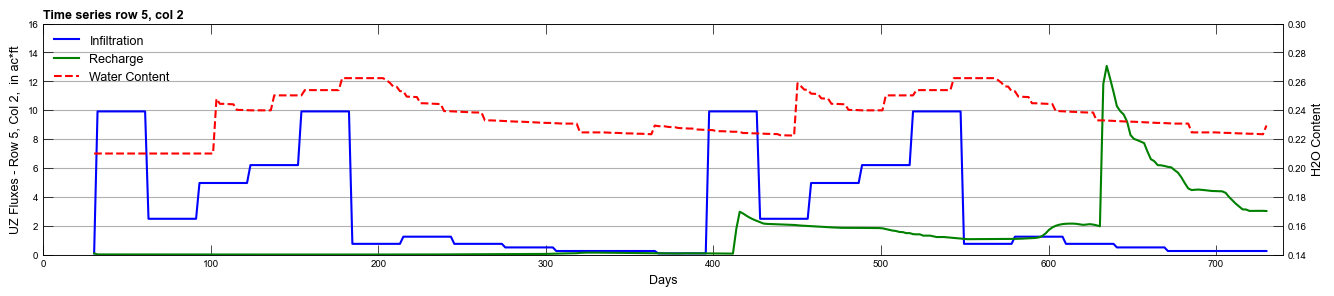

In [10]:
#%%capture  
def plot_uzfcolumn_results(idx, gwf, silent=True):
    with styles.USGSPlot():
        tt = 86400 / 43560     ; UZF_D = pd.read_csv(os.path.join(T13, "obs_uzf_column.csv"), header=0)                  ;      UZF_D["time_days"] = UZF_D["time"] / 86400
        x= UZF_D["time_days"]  ; FIN   = UZF_D["ID26_INFIL"]*tt       ; RCH =(UZF_D["ID26_RCH"] +UZF_D["ID126_RCH"])*tt  ; wc = UZF_D["ID26_DPTH=20"]
        fig = plt.figure(figsize=(16, 3)) 
        ax1 = fig.add_subplot(111) ; ln1 = ax1.plot(x,FIN, color="b", label="Infiltration")                              ; ln2 = ax1.plot(x, RCH, color="g" , label="Recharge")  
        ax2 = ax1.twinx()          ; ln3 = ax2.plot(x, wc, "r--"    , label="Water Content")                             ; LN = ln1 + ln2 + ln3       ; LAB = [l.get_label() for l in LN]     
        ax1.set_xlabel("Days") ;ax1.set_xlim(0,740)            ; ax1.set_ylim(0,16) ; ax1.yaxis.grid("on")               ; ax1.legend(LN, LAB, loc="upper left")
        ax2.set_ylim(0.14,0.3) ;ax2.set_ylabel("H2O Content")  ; styles.heading(heading="Time series row 5, col 2")      ; ax1.set_ylabel("UZ Fluxes - Row 5, Col 2,  in ac*ft")  
        fig.savefig(T13 / '_FIG4')                                                                                      #; os.startfile(T13 / '_FIG4.png')      # plt.show()
        if plot_show: plt.show()
def plot_results(idx, sim, silent=True): gwf = sim.get_model(ID)                             ; plot_uzfcolumn_results(idx, gwf, silent=silent)
def simulation(idx, silent=True): 
    sim = build_models()
    if plot: plot_results(idx, sim, silent=silent)    
simulation(0)

In [8]:
sim = flopy.mf6.MFSimulation.load(sim_ws= T13 ,exe_name=exe_name, verbosity_level=0)         ; gwf = sim.get_model(ID)   
print("OC package_Flow  : ", gwf.oc.output.methods())          ; mvr = gwf.get_package("MVR-1")  ; #mvr_Q = mvr.output.budget()        

OC package_Flow  :  ['list()', 'zonebudget()', 'budget()', 'budgetcsv()', 'head()']


In [9]:
obs=sim.get_model().sfr.output.obs().get_data() ;p0=pd.DataFrame(obs) ;p1=p0.rename(columns=lambda x:'a'+str(x)) ;p1.to_csv(T13/"c5_sfr.output.csv")
obs=sim.get_model().lak.output.obs().get_data() ;p0=pd.DataFrame(obs) ;p1=p0.rename(columns=lambda x:'a'+str(x)) ;p1.to_csv(T13/"c6_lak.output.csv")
p0=pd.DataFrame(SFR_P) ;p1=p0.rename(columns=lambda x:'a'+str(x)) ; p2=p1['a1'].apply(pd.Series) ;p3=p2.rename(columns=lambda x:'b'+str(x)) 
p4=pd.concat([p3[:],p1[:]],axis=1) ; p4.to_csv(T13/"c2_SFR_P.csv") 
SFR_P_pd=p4                  
p0=pd.DataFrame(UZF_P) ;p1=p0.rename(columns=lambda x:'a'+str(x)) ;p2=p1['a1'].apply(pd.Series) ;p3=p2.rename(columns=lambda x:'b'+str(x)) 
p4=pd.concat([p3[:],p1[:]],axis=1) ; p4.to_csv(T13/"c1_UZF_P.csv") 
mvr_sp2=pd.DataFrame.from_dict(MVR_S,orient='index')                         ;mvr_sp2 #mvr_sp2.to_csv(T13/"c4_MVR_S.csv")

,0,1,2,3,4,5,6,7,8,9,...,104,105,106,107,108,109,110,111,112,113
0,"(SFR-1, 22, LAK-1, 0, FACTOR, 1.0)","(LAK-1, 0, SFR-1, 23, FACTOR, 1.0)","(SFR-1, 28, LAK-1, 1, FACTOR, 1.0)","(LAK-1, 1, SFR-1, 29, FACTOR, 1.0)","(UZF-1, 0, SFR-1, 0, FACTOR, 1.0)","(UZF-1, 1, SFR-1, 1, FACTOR, 1.0)","(UZF-1, 2, SFR-1, 1, FACTOR, 1.0)","(UZF-1, 3, SFR-1, 1, FACTOR, 1.0)","(UZF-1, 4, SFR-1, 2, FACTOR, 1.0)","(UZF-1, 5, SFR-1, 10, FACTOR, 1.0)",...,"(WEL-1, 0, UZF-1, 37, FACTOR, 1.0)","(WEL-1, 1, UZF-1, 38, FACTOR, 1.0)","(WEL-1, 2, UZF-1, 47, FACTOR, 1.0)","(WEL-1, 3, UZF-1, 48, FACTOR, 1.0)","(WEL-1, 4, UZF-1, 55, FACTOR, 1.0)","(WEL-1, 5, UZF-1, 56, FACTOR, 1.0)","(WEL-1, 6, UZF-1, 63, FACTOR, 1.0)","(WEL-1, 7, UZF-1, 64, FACTOR, 1.0)","(WEL-1, 8, UZF-1, 71, FACTOR, 1.0)","(WEL-1, 9, UZF-1, 72, FACTOR, 1.0)"
